<a href="https://colab.research.google.com/github/fatday/STATS-305B-HW4-Group/blob/main/hw4_fixing_details_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# HW4: Large Language Models

In this assignment, you will be implementing language models for next token prediction and generation of Shakespeare! This assignment will be in two parts. **For this final assignment, you have the option to work in pairs.**

**Part 1:**

In this part, you will review some key ingredients of sequence modeling. In the process, you will build a baseline transformer model for next token prediction trained on Shakespeare's works. We have provided the scaffoldin for the code in this part of the assignment, and your task will be to fill in the key implementation steps.

**Part 2:**

This part is an open-ended mini-project where you have the freedom to try sequence modeling approaches of your choice on this problem. You should feel free to try other architectures (HMMs, RNNs, transformers, state space layers, diffusion models etc.) or to invent new architectures. You may also experiment with new algorithms for fitting or training these models. The goal will be to find some area of possible improvement (we interpret "improvement" quite loosely, but it is up to you to state precisely why your proposed innovation might constitute an improvement and to show convincing evidence that your innovation does or does not); to formulate and state a precise hypothesis; and to falsify or support the hypothesis with rigorous empirical analyses.

**Deliverables:**

- Code for Parts 1 of the assignment
- A written report of at most 4 pages for Part 2 (references not included in the page limit), with a link to code for Part 2.

_Note: the code for Part 2 will not be graded, but we ask you to include a link to it for completeness._

**Important: Choosing runtimes**

Google Colab has limits on the free usage of GPU runtimes. For this assignment, **we strongly recommend doing the majority of your prototyping, testing, and small-scale experiments on CPU backend**. Then, once you are ready to train your models, you should switch to a T4 GPU.

You can change runtime type by clicking **Runtime -> Change Runtime Type** in the tabs above. You can monitor your resource usages in the top right corner of the screen (it should say what backend you are using, how many compute units per hour you are using, etc.)

**Make sure to turn off GPU runtime if you are not actively using it!**






## Setup

In [1]:
# torch imports
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import matplotlib.pyplot as plt
from tqdm import tqdm
import requests
import os

torch.manual_seed(305)

device = 'cuda' if torch.cuda.is_available() else 'cpu'

We set default values for some global hyperparameters, but feel free to change these during development as needed.

In [2]:
# Global hyperparameters
SMALL_ITERS = 1000
LARGE_ITERS = 2000
EVAL_ITERS = 100
CONTEXT_WINDOW_SIZE = 256

## Part 0: Preprocessing

As in the previous problem sets, a certain amount of preprocessing for textual data is required.

### 0.1: Loading and preprocessing the dataset


The first step is to download the dataset. We will be using a dataset from Andrej Karpathy consisting of a subset of works from Shakespeare.

The dominant mode for preprocessing textual data is to tokenize it; that is, to split the dataset into a finite vocabulary of tokens. Then, we can set up a dictionaries mapping from counting numbers (representing tokens) to tokens and vice versa. Tokens can be characters, or words, or subwords; in fact, the "best" way to tokenize text is an active area of research.

To keep things simple, we'll tokenize the text on a per-character level.

In [3]:
# download the tiny shakespeare dataset
input_file_path = 'input.txt'

if not os.path.exists(input_file_path):
    data_url = 'https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt'
    with open(input_file_path, 'w') as f:
        f.write(requests.get(data_url).text)

with open(input_file_path, 'r') as f:
    data = f.read()
print(f"length of dataset in characters: {len(data):,}")

length of dataset in characters: 1,115,394


In [4]:
# get all the unique characters that occur in this text
chars = sorted(list(set(data)))
vocab_size = len(chars)
print("all the unique characters:", ''.join(chars))
print(f"vocab size: {vocab_size:,}")

all the unique characters: 
 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
vocab size: 65


In [5]:
# create a mapping from characters to integers
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }

def encode(s):
    return [stoi[c] for c in s] # encoder: take a string, output a list of integers
def decode(l):
    return ''.join([itos[i] for i in l]) # decoder: take a list of integers, output a string

# create the train and test splits
n = len(data)
train_chars = data[:int(n*0.9)]
val_chars = data[int(n*0.9):]

# encode both to integers
train_data = encode(train_chars)
val_data = encode(val_chars)

# cast as torch tensors
train_data = torch.tensor(train_data)
val_data = torch.tensor(val_data)

print(f"train has {len(train_data):,} tokens")
print(f"val has {len(val_data):,} tokens")

train has 1,003,854 tokens
val has 111,540 tokens


We also write helper functions to get batches of data and to evaluate the loss of various models on them.

In [6]:
# function for getting batches of data
def get_batch(split, context_window_size, device, batch_size=32):
    """
    generate a small batch of data of inputs x and targets y

    Args:
        split: 'train' or 'val'
        device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    data = train_data if split == 'train' else val_data
    ix = torch.randint(len(data) - context_window_size, (batch_size,))
    x = torch.stack([data[i:i+context_window_size] for i in ix])
    y = torch.stack([data[i+1:i+context_window_size+1] for i in ix])
    x = x.to(device)
    y = y.to(device)
    return x, y

# helper function for tracking loss during training
# given to you
@torch.no_grad()
def estimate_loss(model, eval_iters, context_window_size, device):
    """
    Args:
      model: model being evaluated
      eval_iters: number of batches to average over
      context_window_size: size of the context window
      device: 'cpu' or 'cuda' (should be 'cuda' if available)
    """
    out = {}
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split, context_window_size, device)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    return out

## Part 1: Language Modeling

In this first part of the assignment, we will implement a baseline for code modeling.

In the process of building this baseline, we will review 4 key ideas of sequence modeling that have become the backbone of modern language models such as ChatGPT:

1. Framing language modeling as next token prediction, and next token prediction as multiclass logistic regression
2. Embedding discrete tokens in continuous latent spaces (word embeddings)
3. Use the attention mechanism to move beyond Markovian models for sequences (we of course pay for this greater expressivity with increased compute, which is made possible in part by using matrix multiplications on hardware accelerators like GPUs. Reducing the compute burden while maintaining the expressivity needed for good sequence modeling is an active area of research).
4. Combining attention with deep learning in the Transformer architecture.

### 1.1: Next token prediction as multiclass logistic regression

Our first language model will simply be a lookup table. That is, given that we have token with value $v$, we will simply "look up" the logits that correspond to our prediction for the next token. This model is often known as a "bigram model" because it can be derived from the relative proportions of different bigrams (ordered pairs of tokens) occurring in a large text corpus.

Let us be a bit more precise in our definition of the bigram model. Let's say that the total size of our vocabulary (the number of tokens we are using) is $V$. Let $A$ be a matrix in $\mathbb{R}^{V \times V}$, where each row $A_v$ corresponds to the logits for the prediction of which token would follow a token that has value $v$.
Thus, we are modeling the distribution of the token following a token that has value $v$ as
\begin{align*}
y_{t+1} \mid y_t &= v \sim \mathrm{Cat}(\mathbf{\pi}) \\
\pi &=\mathrm{softmax}(A_v)
\end{align*}

#### Question 1.1.1

$\mathbf{\pi} \in \Delta_{V-1}$ is the vector of probabilities used to parameterize the categorical distribution for the next token prediction. Explain why we parameterize
\begin{equation*}
  \mathbf{\pi} = \mathrm{softmax}(A_v),
\end{equation*}
and could not just use
\begin{equation*}
  \mathbf{\pi} = A_v.
\end{equation*}

**Answer:**
The vector $\pi$ represents a probability distribution over the next token in the sequence. This means that $\pi$ must satisfy the following properties:
1. Non-negativity: Each element of $\pi$ must be non-negative, i.e., $\pi_i \geq 0$ for all $i$.
2. Sum to one: The probabilities must sum to one, i.e., $\sum_i \pi_i=1$.

The values in $A_v$ are logits, meaning they are unconstrained real values. If we were to directly set $\pi=A_v$, then $\pi$ would not necessarily satisfy the constraints of a probability distribution because the elements of $A_v$ can be arbitrary real numbers.


#### Question 1.1.2

Discuss the relationship between the bigram model and contigency tables (discussed in Lecture 1).

**Answer**:

Contingency table represents a sample from a **joint distribution** two categorical random variables:

$$
X\in \{ 1,2,....,I\} \ \ \ \ \ \text{and} \ \ \  \ \ \ Y\in \{1,2,...,J\}
$$

where the table can be written as

$$
\Pi=
\begin{bmatrix}
\pi_{11}&\ldots&\pi_{1J}\\
\vdots&&\vdots\\
\pi_{1I}&\ldots&\pi_{IJ}
\end{bmatrix}
\ \ \ \ \ \text{where} \ \ \  \ \ \ \pi_{ij}=P(X=i,Y=j)
$$

A bigram model estimates the probability of a token given the previous token, typically represented as a conditional probability:

$$
P(y_{t+1} | y_t).
$$

This can be similarly represented as a contingency table for the case $I=J=V$, where rows correspond to the previous token $ y_t $ and columns correspond to the next token $ y_{t+1} $. Each cell in the table contains the probability:

$$
P(y_{t+1} =w| y_t=v)=\frac{\exp(A_{v,w})}{\sum_{w}\exp(A_{v,w})}
$$

which has the similar structure as $\pi_{w\mid v}$ in contingency table. Thus, the bigram model can be viewed as a normalized (in row) contingency table representing transition probabilities between tokens.


#### Question 1.1.3

Say I have a string of three tokens with ids $(7, 3, 6)$. If I use the bigram model as a generative model for language, given this information, what is distribution of the fourth token? Write your answer in terms of the matrix $A$ we defined in 1.1

**Answer:**

The bigram model determines the distribution of the next token based only on the most recent token. Given the sequence of token IDs $ (7, 3, 6) $, the last observed token is $ 6 $.

According to the bigram model, the probability distribution of the fourth token is given by:

$$
P(y_4 | y_3 = 6) = \text{Cat}(\pi), \quad \text{where} \quad \pi = \text{softmax}(A_6).
$$

Here, $ A_6 $ is the row of the matrix $ A $ corresponding to token $ 6 $, and applying the softmax function ensures that we obtain a valid probability distribution over possible next tokens.


#### Question 1.1.4

Remember back in Part 0 when we gave you the helper function `get_batch`? Run `get_batch` and look at the inputs `x` and the targets `y`. Explain any relation between them in the context of formulating language modeling in the context of next token prediction.

In [ ]:
xb, yb = get_batch('train', 10, device, batch_size = 1)
print(f"the features have token ids {xb}")
print('\n')
print(f"the targets have token ids {yb}")

the features have token ids tensor([[47, 53, 59, 57,  1, 50, 53, 60, 43,  6]])


the targets have token ids tensor([[53, 59, 57,  1, 50, 53, 60, 43,  6,  0]])


**Anwser:**

In the context of next-token prediction, the input tokens $ x $ serve as features, while the target tokens $ y $ represent the next tokens that should be predicted. Observing the printed tensors:

$
x = [47, 53, 59, 57, 1, 50, 53, 60, 43, 6]
$

$
y = [53, 59, 57, 1, 50, 53, 60, 43, 6, 0]
$

we see that each element in $ y $ is simply the next token that follows the corresponding element in $ x $ (if consider from left to right). That is,

$$
y_t = x_{t+1}.
$$

This structure aligns with the bigram language model, where the goal is to learn the probability distribution $ P(y_t | x_t) $ so that given an input token $ x_t $, the model predicts the next token $ y_t $.


#### Question 1.1.5

Discuss the strengths and weaknesses of the bigram model as a generative model for language.

**Answer:**


**Strengths**:

- Simplicity and Efficiency: The bigram model is easy to implement and computationally efficient compared to more complex models (e.g n-grams).
- Interpretability: The transition probabilities can be directly calculated and analyzed by some simple metrics (e.g frequency counts), so it can easily interpret the model and distribution.
- Works well with sufficient data: When trained on a large corpus, it captures basic statistical relationships between adjacent words.

**Weaknesses**:

- Limited Context (Markov Assumption): The model assumes that the probability of the next token depends only on the previous token, which ignores long-term dependencies that are crucial for understanding language.
- Time-Invariant Transition Probabilities: The model assumes that transition probabilities do not change over time, which cannot reflect how language meaning changes based on context.
- Data Sparsity & Poor Generalization: The model might struggles with rare or unseen bigrams, which would have poor generalization. **This is what when we project the discrete words into continuous embeddings might help, we can see this in 1.2.**


**All in all, we should add more inductive bias that we know about language distibution when designing the models** Thus, while the bigram model is a simple and useful baseline, more sophisticated models such as n-grams, hidden Markov models, or neural language models are needed for better language modeling.


#### Question 1.1.6

Say I have a string $s$ of length $T$. Derive the formula for the negative log likelihood of $s$ under the bigram model in terms of the matrix of logits $A$. What would your answer be if the matrix of logits $A$ were all zeros? What would be the value of the negative log likelihood of $s$ under a model that always perfectly predicted the next token?

**Answer**

Given a sequence $ s = (y_1, y_2, \dots, y_T) $, the negative log-likelihood (NLL) under the bigram model can be written in terms of the matrix of logits \( A \).

1. **Derivation of the Negative Log-Likelihood (NLL):**  
   The probability of the sequence under the bigram model is:

   $$
   P(s) = \prod_{t=1}^{T-1} P(y_{t+1} | y_t)
   $$

   Using the softmax transformation on the logits $ A $, the probability of transitioning from token $y_t$ to $y_{t+1}$ is:

   $$
   P(y_{t+1} | y_t) = \frac{\exp(A_{y_t, y_{t+1}})}{\sum_{j} \exp(A_{y_t, j})}
   $$

   The negative log-likelihood is then:

   $$
   -\log P(s) = -\sum_{t=1}^{T-1} \log P(y_{t+1} | y_t)
   $$

   Substituting the softmax probability:

   $$
   -\sum_{t=1}^{T-1} \log \frac{\exp(A_{y_t, y_{t+1}})}{\sum_{j} \exp(A_{y_t, j})}
   $$

   Which simplifies to:

   $$
   \sum_{t=1}^{T-1} \left[ \log \left(\sum_{j} \exp(A_{y_t, j}) \right)- A_{y_t, y_{t+1}} \right].
   $$

2. **Case when $ A $ is all zeros:**  
   If all elements of $ A $ are zero, then:

   $$
   P(y_{t+1} | y_t) = \frac{\exp(0)}{\sum_{j} \exp(0)} = \frac{1}{V}.
   $$

   so the next token follows a uniform discrete distribution, which is randomly picking word from vocabulary, and the negative loglikelihood can simplify to:

   $$
   \sum_{t=1}^{T-1} \left[ \log \left(\sum_{j} \exp(0) \right)- 0 \right]= \sum_{t=1}^{T-1} \log V = (T-1) \log V.
   $$

3. **Case when the model predicts the next token perfectly:**  
   If the model perfectly predicts the next token, then:

   $$
   P(y_{t+1} | y_t) = 1.
   $$

   This means:

   $$
   -\sum_{t=1}^{T-1} \log 1 = 0.
   $$

Thus, the negative log-likelihood is zero when the model makes perfect predictions in sequence $s$.

#### Question 1.1.7: Implement the BigramLanguageModel

Implement the bigram language model below.

Your TODOs:
  * if the `forward` method is provided a target, the loss should be the negative log likelihood of the target (given the context)
  * `generate` should take in (batched) contexts and a number of new tokens to generate, and then generate text autoregressively from your model. Note that in autoregressive text generation, you iteratively append the tokens you generate to your context.


In [ ]:
class BigramLanguageModel(nn.Module):

    def __init__(self, vocab_size):
        """
        Args:
          vocab_size: size of the vocabulary (the number of tokens)
        """
        super().__init__()
        # each token directly reads off the logits for the next token from a lookup table
        self.logits_table = nn.Embedding(vocab_size, vocab_size)
        self.vocab_size = vocab_size

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: Int(B, T), token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: Int(B, T), token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """

        # idx and targets are both (B,T) tensor of integers
        logits = self.logits_table(token_ids) # (B,T,V)

        if targets is None:
            loss = None
        else:
            # TODO: what should the loss in this setting be?
            # implement the log-likelihood
            B, T, V = logits.shape
            logits = logits.view(B*T, V)
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=CONTEXT_WINDOW_SIZE):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        B,T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
            logits, loss = self(token_ids)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            new_tokens = torch.multinomial(probs, num_samples=1)
            new_token_sequences[:, T + t] = new_tokens

        return new_token_sequences


#### Question 1.1.8: Evaluating the initialization.

Evaluate the loss of your untrained bigram model on a batch of data. Make sure the loss (negative log likelihood) is per-token (i.e. you may need to average over both sequence length and batch). Does this loss make sense in the context of your answer to Question 1.1.6? Discuss.

In [ ]:
x,y = get_batch("train", CONTEXT_WINDOW_SIZE, device)
bigram_model = BigramLanguageModel(vocab_size)
bm = bigram_model.to(device)

# TODO: your code below
import math
logits, loss = bm(x,y)
print(f"loss (average per token): {loss}, vocab size = {vocab_size}, T = {CONTEXT_WINDOW_SIZE}")
print(f"loss (average per sequence): {loss * (CONTEXT_WINDOW_SIZE - 1)}")
print(f"loss (when logit A are all 0 - random guess) = {(CONTEXT_WINDOW_SIZE-1) * math.log(vocab_size)}")

loss (average per token): 4.623427867889404, vocab size = 65, T = 256
loss (average per sequence): 1178.97412109375
loss (when logit A are all 0 - random guess) = 1064.4687538233875


**Answer**:
In 1.1.6 the loss of a sequence when logit are all $0$ is

$$
(T-1)\log V=255\cdot \log 65\approx 1064.469
$$

but our **average loss per sequence** from above result is **higher** than the $1064.469$. In this case, it make sense since this is the **untrained model** and the **initial** **nn.Embedding** will output the logit $A$ that each entry follow $N(0,1)$. This randomlization will possibly result the logit $A$ that worse than logit $A$ would randomly guess the next token.

#### Question 1.1.9: Training your bigram model

Train your bigram model for `SMALL_ITERS` iterations. Plot and interpret the loss curve.

Our train loss gets down to around 2.5 after 1000 iterations.

In [ ]:
# create a PyTorch optimizer
learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = bm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  1%|▏         | 13/1000 [00:00<00:48, 20.40it/s]

step 0: train loss 4.6189, val loss 4.6175


 19%|█▉        | 189/1000 [00:02<00:06, 127.11it/s]

iteration 200


 22%|██▏       | 216/1000 [00:03<00:15, 51.89it/s]

step 200: train loss 2.9109, val loss 2.9177


 39%|███▉      | 389/1000 [00:04<00:05, 122.03it/s]

iteration 400


 41%|████▏     | 414/1000 [00:05<00:12, 46.94it/s]

step 400: train loss 2.5624, val loss 2.5822


 59%|█████▉    | 593/1000 [00:06<00:03, 127.93it/s]

iteration 600


 62%|██████▏   | 617/1000 [00:07<00:07, 48.84it/s]

step 600: train loss 2.4972, val loss 2.5245


 80%|████████  | 800/1000 [00:09<00:02, 87.93it/s]

iteration 800


 82%|████████▏ | 823/1000 [00:11<00:04, 36.97it/s]

step 800: train loss 2.4826, val loss 2.5061


100%|█████████▉| 996/1000 [00:12<00:00, 124.09it/s]

iteration 999


100%|██████████| 1000/1000 [00:13<00:00, 76.05it/s]

step 999: train loss 2.4733, val loss 2.4975


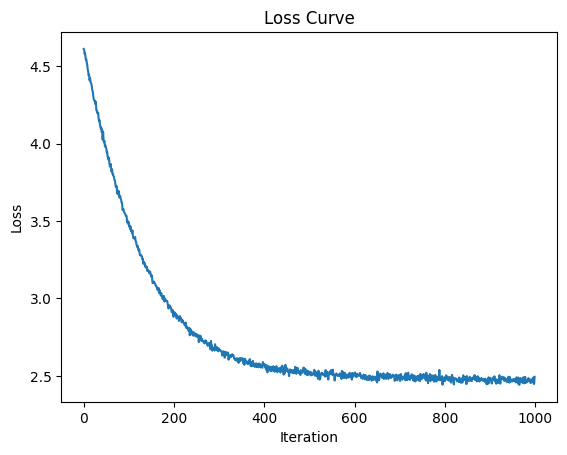

In [ ]:
# Plot and interpret the loss curve.
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

**Answer**

The given plot represents the training loss curve for the bigram model over 1000 iterations. The loss is the negative log-likelihood (NLL) of the training data under the model's learned probability distribution.

$\textbf{For Loss Curve:}$
- Initially, the loss is high (around 4.6), which is expected since the model starts with random parameters and has not yet learned meaningful token transitions.
- As training progresses, the loss rapidly decreases, indicating that the model is improving its ability to predict the next token.
- After approximately 600 iterations, the loss stabilizes around 2.5, implying that the model has learned a reasonable probability distribution over bigrams in the dataset.


$\textbf{For Final Loss Value:}$
- A final loss of around 2.5 suggests that the model has learned a probability distribution better than uniform guessing (loss = $\log V $).
- The fact that the loss does not reach zero means the model is not making perfect predictions, which is expected in language modeling due to inherent uncertainty and variability in real text.



Note that these models can take up a lot of memory on the GPU. As you go through this assignment, you may want to free the models after you train them using code along the lines of
```
model.to('cpu')
torch.cuda.empty_cache()
```

In [ ]:
bigram_model.to('cpu')
torch.cuda.empty_cache()

### 1.2: Token Embeddings: going from discrete tokens to continuous latent spaces

In the look up table formulation of the bigram model, we are modelling the logits of the next token didstirbution independently for each token, even if two tokens are extremely similar to each other.
One way arond this problem is to learn an embedding of the discrete tokens into $\mathbb{R}^{D}$, and then to run multi-class logistic regression on top of this learned embedding.

More precisely, if we have a vocabulary of tokens of size $V$ that we choose to embed in a Euclidean embedding space of dimension $D$, we can parameterize the distribution of the next token if the current token is $v$ according to
\begin{align*}
  \mathrm{Cat}\Big( \mathrm{softmax} (\beta X_v) \Big),
\end{align*}
where $X_v \in \mathbb{R}^{D}$ is the learned embedding of token $v$ into $\mathbb{R}^{D}$ and $\beta \in \mathbb{R}^{V \times D}$. Notice that if $X$ were a fixed design matrix this formulation would be equivalent to multi-class logistic regression. However, both $X$ and $\beta$ are learnable parameters.

#### Question 1.2.1: Implement BigramWithWordEmbeddingsLM

Implement a bigram languge model that uses a linear readout from a low dimensional Euclidean embedding of each token to parameterize the logits of the next token distribution, instead of parameterizing the logits of the next token distribution directly. It should have almost the same implementation as `BigramLanguageModel` from Question 1.1.6, except `init` should also take in an `embed_size`, and the `forward` method will need to be modified.

In [ ]:
class BigramWithWordEmbeddingsLM(nn.Module):

    def __init__(self, vocab_size, embed_size=32):
      """
      Args:
        vocab_size: int, size of the vocabulary
        embed_size: int, dimension of the word embedding (D)
      """
      super().__init__()
      #TODO, your code here
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t, :] gives the length V vector of logits for the next token prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO, your code here

        logits = self.token_embedding_table(token_ids)
        logits = self.lm_head(logits)

        if targets is None:
            loss = None
        else:
          B, T, V = logits.shape
          logits = logits.view(B*T, V)
          targets = targets.view(B*T)
          loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens=CONTEXT_WINDOW_SIZE):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for t in range(max_new_tokens):
            logits, loss = self(token_ids)
            logits = logits[:, -1, :]
            probs = F.softmax(logits, dim=-1)
            new_tokens = torch.multinomial(probs, num_samples=1)
            new_token_sequences[:, T + t] = new_tokens
        return new_token_sequences


#### Question 1.2.2: Training your bigram model with word embeddings

Train your bigram model with word embeddings for `SMALL_ITERS` iterations. Plot and interpret the loss curve. How does the final loss compare to that of the bigram model without embeddings? Why do you think this is?

Our train loss gets down to around 2.5 after 1000 iterations.

In [ ]:
bigram_model_embed = BigramWithWordEmbeddingsLM(vocab_size)
bm_e = bigram_model_embed.to(device)

learning_rate = 1e-2
optimizer = torch.optim.AdamW(bigram_model_embed.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(bm_e, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = bm_e(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  1%|          | 8/1000 [00:01<02:16,  7.25it/s]

step 0: train loss 4.4024, val loss 4.3897


 20%|█▉        | 197/1000 [00:03<00:08, 92.64it/s]

iteration 200


 22%|██▏       | 217/1000 [00:05<00:24, 32.30it/s]

step 200: train loss 2.4754, val loss 2.4995


 40%|███▉      | 397/1000 [00:07<00:06, 88.60it/s]

iteration 400


 42%|████▏     | 416/1000 [00:08<00:18, 32.18it/s]

step 400: train loss 2.4645, val loss 2.4834


 60%|█████▉    | 596/1000 [00:10<00:04, 92.22it/s]

iteration 600


 62%|██████▏   | 616/1000 [00:11<00:11, 32.56it/s]

step 600: train loss 2.4606, val loss 2.4858


 80%|████████  | 800/1000 [00:13<00:02, 68.19it/s]

iteration 800


 81%|████████  | 807/1000 [00:14<00:12, 15.41it/s]

step 800: train loss 2.4626, val loss 2.4827


 99%|█████████▉| 990/1000 [00:17<00:00, 94.70it/s]

iteration 999


100%|██████████| 1000/1000 [00:18<00:00, 55.08it/s]

step 999: train loss 2.4613, val loss 2.4954


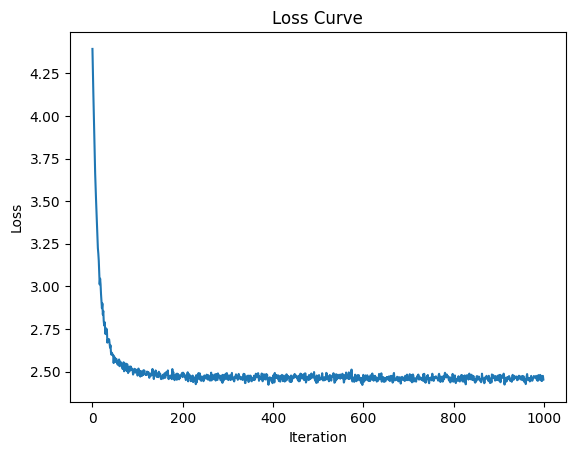

In [ ]:
# Plot and interpret the loss curve.
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

---

# Answer

As we can see in this plot, the loss converges to around 2.5 much faster when compares to the bigram model without embeddings (only takes around 200 iterations).

That is because our embedding modelling maps the tokens to a lower dimension space and the linear model can generalize the information of the tokens, so it can capture the information in similar tokens easily. The bigram model working on the next token's logits of each token, in this case the dimension will be high which will take a lot more time than our embedding modelling. Moreover, in bigram model is doing optimization is discrete space while the embedding modelling is working on continuous latent spaces, this continuous space makes the gradient-decent based optimization more efficient.

---

In [ ]:
bigram_model_embed.to('cpu')
torch.cuda.empty_cache()

### 1.3: Attention: Relaxing Markovian assumptions to transmit information across the sequence length

A major problem with the bigram models of Sections 1.1 and 1.2 was that they were Markovian: the distribution of the next token was determined entirely by the current token! The attention mechanism provides a way to extract information between the previous tokens in the context to provide a better parameterization for the distribution of the next token.

#### Question 1.3.1: Averaging over word embeddings

One simple way to pool information would simply be to average the embeddings!

Your TODO: Add comments to the the code snippet below. Write a description here explaining why the code is mathematically equivalent to averaging the embeddings of the previous tokens and the current token.

### Answer：
The attention matrix $\boldsymbol{A}$ (all description below used 0-indexed) is computed from a strictly lower triangular mask:
$$
A_{i j}=\frac{\mathbb{I}(j \leq i)}{i+1}
$$
where $\mathbb{I}(j \leq i)$ is an indicator function that is 1 if $j \leq i$ and 0 otherwise. Applying softmax ensure that each row sums to 1 .

The average embeddings are computed as:
$$
\text { avg_embeddings }=A X
$$
which results in:
$$
\text { avg_embeddings }[t]=\frac{1}{t+1} \sum_{i=0}^{t-1} X[i]
$$

This formula shows that each embedding at time $t$ is the arithmetic mean of all embeddings from (0-indexed) $t=0$ to $t-1$, proving that the implementation is mathematically equivalent to averaging the embeddings of previous and current tokens.


In [ ]:
# average word embedding via matrix multiply and softmax
small_batch_size = 4              # B
small_context_window_size = 8     # T
small_embed_size = 2              # D

# make "synthetic" word embeddings (for illustration purposes only)
X = torch.randn(small_batch_size, small_context_window_size, small_embed_size)

# TODO: comment the code below
print(X.shape)
tril = torch.tril(torch.ones(small_context_window_size, small_context_window_size))
attn_weights = torch.zeros((small_context_window_size, small_context_window_size))
attn_weights = attn_weights.masked_fill(tril == 0, float('-inf'))
attn_weights = F.softmax(attn_weights, dim=-1)
avg_embeddings = attn_weights @ X
print(X[0])
print("")
print(avg_embeddings[0])

torch.Size([4, 8, 2])
tensor([[-0.0812, -1.8482],
        [ 0.9644, -1.0071],
        [ 1.0212, -0.2257],
        [-1.6282,  0.3827],
        [ 0.1593, -0.5935],
        [-0.0302, -0.5043],
        [ 0.4907, -1.5719],
        [-1.1143,  1.1583]])

tensor([[-0.0812, -1.8482],
        [ 0.4416, -1.4276],
        [ 0.6348, -1.0270],
        [ 0.0691, -0.6746],
        [ 0.0871, -0.6583],
        [ 0.0676, -0.6327],
        [ 0.1280, -0.7668],
        [-0.0273, -0.5262]])


#### 1.3.2: Single-headed scaled $(Q,K,V)$-attention

A more sophisticated approach than simply averaging over previous word embeddings is single-headed (Query, Key, Value) scaled attention.
That is, we now summarize the information contained in a length $T$ sequence of tokens that have been embeded into $X \in \mathbb{R}^{T \times D}$ according to
\begin{equation}
   \mathrm{SoftmaxAcrossRows} \Bigg( \frac{\mathrm{CausalMask}\Big(X U_q^\top U_k X^\top \Big)}{\sqrt{K}} \Bigg) \Big( X V^\top \Big),
\end{equation}
where $U_q, U_k \in \mathbb{R}^{K \times D}$, $V \in \mathbb{R}^{D \times D}$, and $K$ is the "head size".



##### Question 1.3.2.1

In the limiting case where $U_q$ and $U_k$ are all zeros, and $V = I_{D}$, what does $(U_q, U_k, V)$ attention simplify to?

**Answer**:
It simplifies to uniform averaging.

##### Question 1.3.2.2: Implement single-headed scaled $(U_q,U_k,V)$-attention.

Complete the below code so the `forward` method returns single-headed scaled $(U_q,U_k,V)$-attention.

In [7]:
class Head(nn.Module):
    """ one head of self-attention """

    def __init__(self, head_size, context_window_size, embed_size=384):
        """
        Args:
          head_size: int, size of the head embedding dimension (K)
          context_window_size: int, number of tokens considered in the past for attention (T)
          embed_size: int, size of the token embedding dimension (D)
        """
        super().__init__()
        self.head_size = head_size
        self.key = nn.Linear(embed_size, head_size, bias=False)
        self.query = nn.Linear(embed_size, head_size, bias=False)
        self.value = nn.Linear(embed_size, embed_size, bias=False)

        # not a param of the model, so registered as a buffer
        self.register_buffer('tril', torch.tril(
            torch.ones(context_window_size, context_window_size)))

    def forward(self, x):
        """
        Args:
          x: (B,T,D) tensor of token embeddings

        Returns:
          (B,T,D) tensor of attention-weighted token embeddings
        """
        # TODO: your code here
        B,T,D = x.shape
        k = self.key(x)
        q = self.query(x)
        v = self.value(x)
        wei = q @ k.transpose(-2,-1) * self.head_size**-0.5
        tril = torch.tril(torch.ones(T, T, device=x.device))
        wei = wei.masked_fill(tril == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)  ## wei.shape:
        out = wei @ v
        return out

##### Question 1.3.2.3: Implement a single-headed attention language model

Complete the code below. Note that because the transformer has no idea where tokens are occuring in space, we have also added in position embeddings.

In [8]:
class SingleHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, head_size, embed_size=384):
      """
      Args:
        vocab_size: int, size of the vocabulary (V)
        context_window_size: int, number of tokens considered in the past for attention (T)
        head_size: int, size of the head embedding dimension (K)
        embed_size: int, size of the token embedding dimension (D)
      """
      super().__init__()
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.context_window_size = context_window_size

      # TODO: your code below
      self.atten_head = Head(head_size, context_window_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)

    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry
                     in the batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V) logits[b,t] gives the length V vector of logits for the next token
                   prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        B, T = token_ids.shape # (batch size, length)
        tok_emb = self.token_embedding_table(token_ids) # (B,T,D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T,D)
        x = tok_emb + pos_emb # (B,T,D)
        x = self.atten_head(x) # (B,T,D)
        logits = self.lm_head(x) # (B,T,V)

        # TODO: your code here
        B, T, V = logits.shape
        logits = logits.view(B*T, V)
        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))
        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        #TODO
        # your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        return new_token_sequences

Train your new `SingleHeadedAttentionLM` for `SMALL_ITERS` training iterations and plot the loss curve.
The `head_size` shouldn't matter too much, we just use the `embedding_size`.
Do you seen an improvement compared to your `BigramLanguageModel`? Discuss.

Note: you may want to modify the learning rate. Training for `SMALL_ITERS` with a learning rate of `6e-4`, we can get to a train loss of around 2.3.

In [ ]:
embed_size = 384
sha_model = SingleHeadedAttentionLM(vocab_size, CONTEXT_WINDOW_SIZE, embed_size, embed_size)
sham = sha_model.to(device)
learning_rate = 6e-4
optimizer = torch.optim.AdamW(sha_model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(sham, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(
            f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}"
        )

    # sample a batch of data
    xb, yb = get_batch("train", CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = sham(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  1%|          | 11/1000 [00:01<01:26, 11.42it/s]

step 0: train loss 4.1596, val loss 4.1590


 19%|█▉        | 193/1000 [00:03<00:09, 89.36it/s]

iteration 200


 21%|██        | 210/1000 [00:04<00:27, 29.01it/s]

step 200: train loss 2.5859, val loss 2.5918


 39%|███▉      | 392/1000 [00:06<00:06, 87.84it/s]

iteration 400


 41%|████      | 411/1000 [00:07<00:19, 30.35it/s]

step 400: train loss 2.4923, val loss 2.5154


 60%|█████▉    | 599/1000 [00:09<00:04, 86.95it/s]

iteration 600


 62%|██████▏   | 617/1000 [00:11<00:12, 30.32it/s]

step 600: train loss 2.3949, val loss 2.4291


 80%|███████▉  | 799/1000 [00:13<00:02, 86.91it/s]

iteration 800


 81%|████████  | 808/1000 [00:14<00:08, 22.88it/s]

step 800: train loss 2.3497, val loss 2.3980


100%|█████████▉| 997/1000 [00:16<00:00, 86.98it/s]

iteration 999


100%|██████████| 1000/1000 [00:17<00:00, 57.47it/s]

step 999: train loss 2.3299, val loss 2.3743


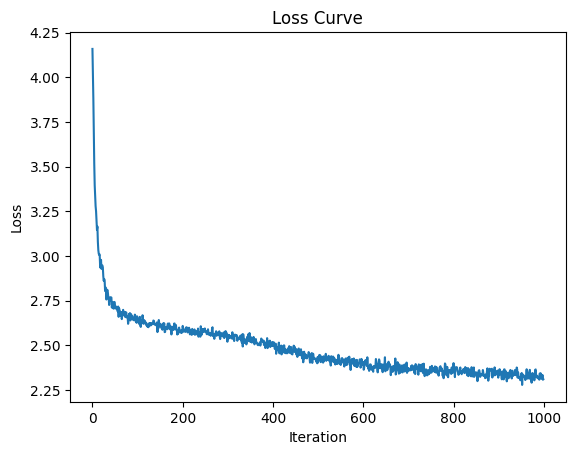

In [ ]:
## plot the loss_curve
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

---

# Answer

As we can see in this plot, the loss converges to around 2.3, which is quite lower  compareing to the bigram model with embeddings. That is because the besides the current state, the infomation of previous states can help predict next tokens.

---

In [ ]:
sha_model.to('cpu')
torch.cuda.empty_cache()

#### 1.3.3: Multi-headed attention

##### Question 1.3.3.1: Implement multi-headed attention

In [9]:

class MultiHeadAttention(nn.Module):
    def __init__(self, context_window_size, num_heads, embed_size):
        super().__init__()
        self.num_heads = num_heads
        self.head_size = embed_size // num_heads  # 确保总维度匹配

        self.heads = nn.ModuleList(
            [Head(self.head_size, context_window_size, embed_size) for _ in range(num_heads)]
        )
        self.proj = nn.Linear(embed_size * num_heads, embed_size)  # 确保总维度匹配
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)  # 拼接 heads

        out = self.dropout(self.proj(out))  # 投影回 embed_size
        return out


##### Question 1.3.3.2: Implement a multi-headed attention LM

Fill in the code below to create a language model that outputs its logits for next token prediction using multi-headed attention. Train your model for `SMALL_ITERS` training iterations. Compare the results with the single-headed attention model. Do you see an improvement?

We get to a train loss of around 2 after 1000 iterations, which takes around 1.5 minutes on a T4 GPU.

In [10]:
class MultiHeadedAttentionLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
      super().__init__()
      self.head_size = embed_size // num_heads
      self.context_window_size = context_window_size
      # TODO: your code below
      self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
      self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
      self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size)
      self.lm_head = nn.Linear(embed_size, vocab_size)


    def forward(self, token_ids, targets=None):
        """
        Args:
          token_ids: (B, T) token ids that make up the context (batch has size B, each entry in the
                     batch has length T)
          targets: (B, T) token ids corresponding to the target of each context in token_ids

        Returns:
          logits: (B, T, V), logits[b,t] gives the length V vector of logits for the next token
                  prediction in string b up to t tokens
          loss: scalar, negative log likelihood of target given context
        """
        # TODO: your code below
        B, T = token_ids.shape
        tok_emb = self.token_embedding_table(token_ids)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.atten_heads(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            logits = logits.view(B*T, -1)
            targets = targets.view(B*T)
            loss = -torch.mean(torch.log(F.softmax(logits, dim=1)[torch.arange(B*T), targets]))

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
          token_ids: (B, T) tensor of token ids to provide as context
          max_new_tokens: int, maximum number of new tokens to generate

        Returns:
          (B, T+max_new_tokens) tensor of context with new tokens appended
        """
        # TODO: your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        return new_token_sequences

In [ ]:
# Initialize model
model = MultiHeadedAttentionLM(vocab_size, CONTEXT_WINDOW_SIZE)
m = model.to(device)

# create a PyTorch optimizer
learning_rate = 6e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(SMALL_ITERS)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == SMALL_ITERS - 1:
        print(f"iteration {it}")
        losses = estimate_loss(m, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
        print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = m(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/1000 [00:00<?, ?it/s]

iteration 0


  0%|          | 4/1000 [00:03<11:03,  1.50it/s]

step 0: train loss 4.1767, val loss 4.1758


 20%|█▉        | 199/1000 [00:12<00:38, 20.73it/s]

iteration 200


 20%|██        | 202/1000 [00:16<05:04,  2.62it/s]

step 200: train loss 2.4461, val loss 2.4720


 40%|████      | 400/1000 [00:25<00:28, 20.97it/s]

iteration 400


 40%|████      | 403/1000 [00:29<03:44,  2.66it/s]

step 400: train loss 2.1822, val loss 2.2393


 60%|█████▉    | 598/1000 [00:38<00:18, 21.53it/s]

iteration 600


 60%|██████    | 604/1000 [00:41<01:47,  3.67it/s]

step 600: train loss 2.0670, val loss 2.1585


 80%|███████▉  | 799/1000 [00:50<00:09, 21.72it/s]

iteration 800


 80%|████████  | 802/1000 [00:54<01:12,  2.73it/s]

step 800: train loss 1.9857, val loss 2.1090


100%|█████████▉| 997/1000 [01:03<00:00, 21.73it/s]

iteration 999


100%|██████████| 1000/1000 [01:06<00:00, 15.03it/s]

step 999: train loss 1.9391, val loss 2.0787


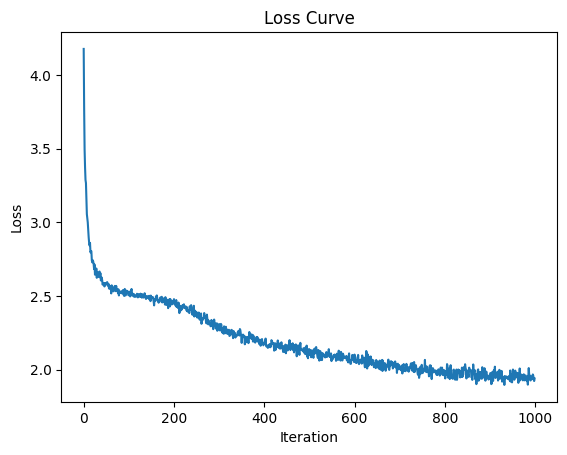

In [ ]:
## plot the loss curve
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

---
### Answer:

Loss Curve Analysis: Impact of Multi-Head Attention on Model Performance
The plot above shows the training loss curve of a model over 1000 iterations. The loss starts above 4.0, decreases sharply in the early iterations, and then gradually converges towards 2.0.

Previously, when using a single-headed attention mechanism, the loss had converged around 2.3. However, after switching to a multi-headed attention mechanism, the loss further reduced to approximately 2.0, indicating an improvement in the model's learning capacity.

The following are the key observations:

1. Lower Final Loss: The model with multi-head attention reaches a lower loss than the single-headed version, suggesting improved expressiveness and generalization.

2. Smooth & Stable Convergence: The curve shows a relatively stable and smooth descent, meaning the model is effectively optimizing without encountering significant instability.

3. Effectiveness of Multi-Head Attention: Multi-head attention allows the model to capture multiple perspectives of the input by attending to different parts of the sequence in parallelly, which can enable better learning and thus reduce the loss.


---

In [ ]:
model.to('cpu')
torch.cuda.empty_cache()

### 1.4: The Transformer Architecture: combining attention with deep learning

In [11]:
# run this cell to initialize this deep learning module that you should use in the code your write later
# you don't need to edit this layer
class FeedForward(nn.Module):
    """ a simple linear layer followed by a non-linearity
        Given to you, you don't need to write any code here!
    """

    def __init__(self, embed_size):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(embed_size, 4 * embed_size),
            nn.ReLU(),
            nn.Linear(4 * embed_size, embed_size),
        )

    def forward(self, x):
        return self.net(x)

#### Question 1.4.1: Implement a transformer block

Complete the code below to implement a transformer block

To make the your implemenation easier to train, we have added two deep learning best practices:

1. Residual connections.

    In the `forward` method of the `TransformerBlock`, we have implemented a residual connection of the form
    
    \begin{align*}
    x \mapsto x + f(x)
    \end{align*}
    
    where $f$ is a nonlinear function. The idea is that every layer is some adjustment of the identity function, which guards against vanishing gradients in a deep network during back propogation, especially at initialization.

2. Prenorm via `LayerNorm`

    Also in the `forward` method of the `TransformerBlock`, the nonlinearity first applied a `LayerNorm` to its arguments. The `LayerNorm` basically standardizes the activations in that layer so that they have mean 0 and variance 1. Doing so is very helpful for numerical stability, espeically of the gradients.

In [12]:
class TransformerBlock(nn.Module):
    """ Transformer block: communication across sequence length, followed by communication across embedding space
        Uses multi-headed attention
    """

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6):
        super().__init__()
        self.ln1 = nn.LayerNorm(embed_size)
        self.ln2 = nn.LayerNorm(embed_size)

        # TODO: your code below
        self.feed_forward = FeedForward(embed_size)
        self.atten_heads = MultiHeadAttention(context_window_size, num_heads, embed_size)

    def forward(self, x):
        x = x + self.atten_heads(self.ln1(x)) # communication over sequence length
        x = x + self.feed_forward(self.ln2(x)) # communication across embedding space
        return x

#### Question 1.4.2: Implement your baseline transformer model

We now stack 6 `TransformerBlocks` (with a final layer norm applied after the blocks but before the logits) to create our basline `TransformerLM`.

In [13]:
class TransformerLM(nn.Module):

    def __init__(self, vocab_size, context_window_size, embed_size=384, num_heads=6, n_layers=6):
        """
          Args:
              vocab_size: int, number of tokens in the vocabulary (V)
              context_window_size: int, size of the context window (T)
              embed_size: int, embedding size (D)
              num_heads: int, number of heads (H)
              n_layers: int, number of layers (M)
        """
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, embed_size)
        self.position_embedding_table = nn.Embedding(context_window_size, embed_size)
        self.blocks = nn.Sequential(*[
            TransformerBlock(vocab_size,
                             context_window_size,
                             embed_size=embed_size,
                             num_heads=num_heads)
            for _ in range(n_layers)])

        # final layer norm
        self.ln_f = nn.LayerNorm(embed_size)
        self.lm_head = nn.Linear(embed_size, vocab_size)

        # good initialization
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)

    def forward(self, token_ids, targets=None):
        """
        Agrgs:
            token_ids: tensor of integers, provides the contet, shape (B, T)
            targets: tensor of integers, provides the tokens we are preidcitng, shape (B, T)
        """
        B, T = token_ids.shape

        # token_ids and targets are both (B, T) tensor of integers
        tok_emb = self.token_embedding_table(token_ids) # (B, T, D)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) # (T, D)
        x = tok_emb + pos_emb # (B, T, D)

        # TODO: your code below
        logits = ...
        loss = ...

        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)

        B, T, V = logits.shape
        logits = logits.view(B*T, V)

        if targets is None:
            loss = None
        else:
            targets = targets.view(B*T)
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    @torch.no_grad()
    def generate(self, token_ids, max_new_tokens):
        """
        Args:
            token_ids: tensor of integers forming the context, shape (B, T)
            max_new_tokens: int, max number of tokens to generate
        """
        # TOOD, your code below
        B, T = token_ids.shape
        new_token_sequences = torch.zeros((B, T+max_new_tokens), dtype=torch.long, device=token_ids.device)
        new_token_sequences[:, :T] = token_ids
        for i in range(T, T+max_new_tokens):
            pos_emb = self.position_embedding_table(torch.arange(T, device=device))
            logits, loss = self(new_token_sequences[:, :i])
            logits = logits.view(B, i, -1)
            logits = logits[:, -1, :] # (B, V)
            probs = F.softmax(logits, dim=-1) # (B, V)
            new_token = torch.multinomial(probs, num_samples=1) # (B, 1)
            new_token_sequences[:, i] = new_token.squeeze(-1) # (B, T+1)
        return new_token_sequences

Train your `TransformerLM` for `LARGE_ITERS` iterations and plot the loss curve. You may want to change the learning rate.

We used a learning rate of `1e-4` and got to a final train loss of around 1.4 in around 15 minutes of training on a T4 GPU.

In [14]:
trans = TransformerLM(vocab_size, CONTEXT_WINDOW_SIZE)
tlm = trans.to(device)
learning_rate = 1e-4
# TODO, your code below

optimizer = torch.optim.AdamW(trans.parameters(), lr=learning_rate)

eval_interval = 200

loss_list = []

for it in tqdm(range(10)):

    # every once in a while evaluate the loss on train and val sets
    if it % eval_interval == 0 or it == LARGE_ITERS - 1:
      print(f"iteration {it}")
      losses = estimate_loss(tlm, EVAL_ITERS, CONTEXT_WINDOW_SIZE, device)
      print(f"step {it}: train loss {losses['train']:.4f}, val loss {losses['val']:.4f}")

    # sample a batch of data
    xb, yb = get_batch('train', CONTEXT_WINDOW_SIZE, device)

    # evaluate the loss
    logits, loss = tlm(xb, yb)
    loss_list.append(loss.detach().item())
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()

  0%|          | 0/10 [00:00<?, ?it/s]

iteration 0
step 0: train loss 4.3102, val loss 4.3048


100%|██████████| 10/10 [00:07<00:00,  1.30it/s]


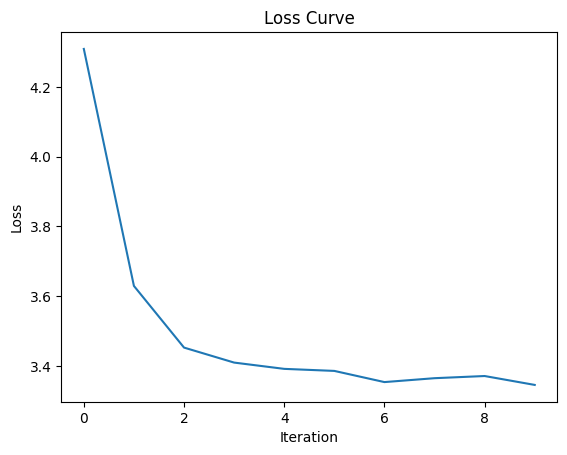

In [15]:
## plot the loss_curve
plt.plot(loss_list)
plt.xlabel('Iteration')
plt.ylabel('Loss')
plt.title('Loss Curve')
plt.show()

#### Question 1.4.3: Generating text!

Now with our trained model, we can generate some text that is somewhat like the style of Shakespeare! Below we will do both unconditional and conditional generation.

In [16]:
# unconditional generation from the model
start_context = torch.zeros((1, 1), dtype=torch.long, device=device)
uncond_gen = (tlm.generate(start_context, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(uncond_gen))


o 'ioOoKvHM
t3.Et
l hibAdmnolJ obOettaMpouet
i Mf
vr tooh,odnI 'D huCyWt WrZ  JE
rmrVrru: x
lI  lxsnKlDmon,auhrooetgou dlqLOV'utew bie yotofeelwtq tcoMtsF? u &em d
enheb le'oy
K
z ,uobOs hi-isLKi eewocrrhe
te  aqtecl
iofsihhufniMfIee hn ijhie  ytbp.a h tt 


In [17]:
# conditional generation from the model

context1 = """ROMEO:
He jests at scars that never felt a wound.
But, soft! what light through yonder window breaks?
It is the east, and Juliet is the sun.
Arise, fair sun, and kill the envious moon,
Who is already sick and pale with grief,
That thou her maid art far more fair than she:
Be not her maid, """

context1_tokens = torch.tensor(encode(context1), device=device).reshape(1, -1)

In [18]:
context1_tokens.shape

torch.Size([1, 290])

In [19]:
cond_gen = (tlm.generate(context1_tokens, max_new_tokens=CONTEXT_WINDOW_SIZE)[0].tolist())
print(decode(cond_gen))

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


TODO: Choose your own context from Shakespeare, and perform conditional generation from that text. Does this look reasonable to you? Why or why not?

In [ ]:
# TODO: your code here

---

_your answer here_

---

In [22]:
torch.cuda.empty_cache()

RuntimeError: CUDA error: device-side assert triggered
CUDA kernel errors might be asynchronously reported at some other API call, so the stacktrace below might be incorrect.
For debugging consider passing CUDA_LAUNCH_BLOCKING=1
Compile with `TORCH_USE_CUDA_DSA` to enable device-side assertions.


#### Question 1.4.4

The negative log-likelihood (averaged per token) we have been using to train our models can be expressed as
\begin{equation*}
  L = -\frac{1}{T} \sum_{t = 1}^{T} \log p(s[t] | \text{context})
\end{equation*}
for some document $s$, where $s[t]$ is the $t$th token of the doc. The natural language processing (NLP) community often reports the quantity
\begin{equation*}
  \text{perplexity} = \exp(L).
\end{equation*}

Give an intuitive interpretation of what perplexity is. Why might it be a more intuitive or natual measure to report than negative log-likelihood? Does the reported perplexity of your trained `TransformerLM` model make sense in terms of samples it generates? (Be sure to distinguish betwen `train` and `validation` perplexity. Which of `train` and `val` perplexity is more helpful for understanding your generated samples? Why?). (*Hint: your answer to Question 1.1.6 may be helpful*).

## Part 2: Mini-Project

Quick recap: So far we have

1. Preprocessed the Shakespeare dataset by encoding individual characters into integer tokens.
2. Implemented single headed attention and then further generalized to multiheaded attention. We further combined multiheaded attention with deep learning to create the transformer architecture.
3. Trained our transformer and generated output that looks to be in the style of Shakespeare.

Up to this point, the performance of our simple language model has clearly made a lot of progress. We can see that our model has learned to generate text that is close to the style of Shakespeare, although there are still many quirks and room for improvement.

### Project Outline

Find some area of possible improvement.
We interpret "improvement" quite loosely, but please state precisely why your proposed innovation might improve the model, and provide evidence that it does (or does not!) improve.
For your idea, **formulate a hypothesis** for why this change should result in a better model. **Implement your changes** and **report any findings**.

_Notes_: As this assignment is being treated as a project, you should expect training to take longer than previous assignments. However, please use your judgement to decide what is reasonable. We will not expect you to run training procedures that take more than 2 hours on the free Google Colab computing resources and we certainly do not expect you to acquire additional compute. The proposed improvements should not solely rely on increased computing demands.

_Hints_: There are many aspects to assessing a model. For example, not only is quality of generated text important, it is also of interest to reduce costs associated with training.

### Deliverables

In addition to a pdf of your python notebook, the submission for this project will be a written report no more than 4 pages in length using the [NeurIPS LaTex template](https://neurips.cc/Conferences/2023/PaperInformation/StyleFiles). Your report should include detailed analysis of the hypotheses you chose to test along with any conclusions.

The page limit for the report does not include bibliography or appendices. Make sure to keep the "ready for submission" option to help us grade anonymously. Your writeup should also contain a link to any code used to generate the project so that we can reference it while grading (Google Drive folder with colab notebooks or Github repo are both fine). You should have at least one plot in your main text (which is capped at 4 pages).

## Submission Instructions

You will generate two PDFs: one from Part 1, which involves completing this Colab to create a transformer baseline; and one from the mini-project in Part 2, which will be your write-up of no longer than 4 pages. Be sure to include a link to your code for Part 2 somewhere in your writeup.

**Combine the two PDFs into a single PDF and submit on gradescope. Tag your PDF correctly.**

If you work in a group of two, submit one assignment on gradescope and tag your group members. If you complete the assignment individually, submit as usual.